# Demo of running TensorFlow model on Predix

by Dattaraj J Rao - Principal Architect - GE Transportation - <a href='mailto:Dattaraj.Rao@ge.com'>Dattaraj.Rao@ge.com</a>

## Imports needed

In [35]:
import numpy as np
import tensorflow as tf

import os
import six.moves.urllib as urllib
import random

from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# Some specific decoding file from Google
from utils import label_map_util

## Setup the environment - define variables

In [36]:
# The image file to use.
IMAGE_FILE = "test.jpg"

# Image size to use for analysis
IMAGE_SIZE = (12, 8)

# The model file to use.
MODEL_NAME = 'ssd_mobilenet_v1_coco_11_06_2017'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_MODEL = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = 'mscoco_label_map.pbtxt'

# Number of classes predicted by the model.
NUM_CLASSES = 90

# This is needed to display the images.
%matplotlib inline

## Load a (frozen) Tensorflow model into memory

In [37]:
# Create the default computational Graph
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    # load graph from the model file 
    with tf.gfile.GFile(PATH_TO_MODEL, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')

## Load the labels and their values

In [38]:
# This will change for your own models
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)

## Helper functions for image handling 

In [39]:
# Convert the read JPG image to numpy array
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Convert the numpy array with image to PIL
def numpy_array_to_PIL(arr, size):
    test = Image.fromarray(arr)
    return test

## Function that actually runs the model and gets results

In [40]:
def run_model(image_np):
    # Define the reurn array
    retimages = {}
    
    # Initate the computation graph
    with detection_graph.as_default():
        with tf.Session(graph=detection_graph) as sess:
            (imgw, imgh) = image_np.shape[0], image_np.shape[1]
            image_np_expanded = np.expand_dims(image_np, axis=0)
            
            # Image tensor will be your input Tensor
            image_tensor = detection_graph.get_tensor_by_name('image_tensor:0')
            
            # These are the results you will read
            boxes = detection_graph.get_tensor_by_name('detection_boxes:0')
            scores = detection_graph.get_tensor_by_name('detection_scores:0')
            classes = detection_graph.get_tensor_by_name('detection_classes:0')
            num_detections = detection_graph.get_tensor_by_name('num_detections:0')
            
            # Run the tensorflow graph with our input image
            (boxes, scores, classes, num_detections) = sess.run(
                [boxes, scores, classes, num_detections],
                feed_dict={image_tensor: image_np_expanded})
            
            # Visualization of the results of detection
            for i in range(0, len(scores[0])):
              if scores is not None and np.any(scores[0][i] > 0.5):
                pixels = np.array(boxes[0,i,:]*np.array([imgw, imgh, imgw, imgh]), dtype=int)
                # get the image detected
                detimg = image_np[pixels[0]-20:pixels[2]+20,pixels[1]-40:pixels[3]+40,:]
                # get the class predicted
                class_name = category_index[np.squeeze(classes).astype(np.int32)[0]]['name']
                # add image to the list to return
                retimages[class_name + str(i+1)] = detimg

    return retimages

## Main code - Run the detection on image

Number of objects detected = 2
airplane1
airplane2


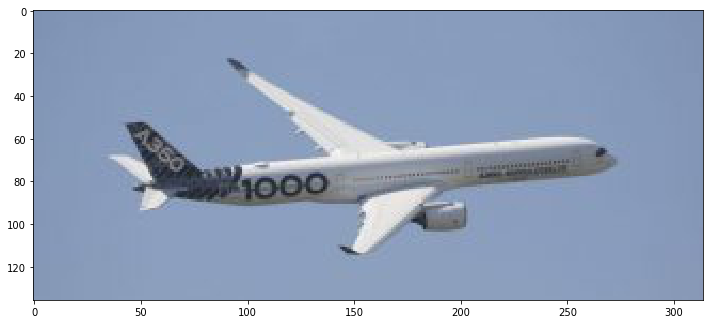

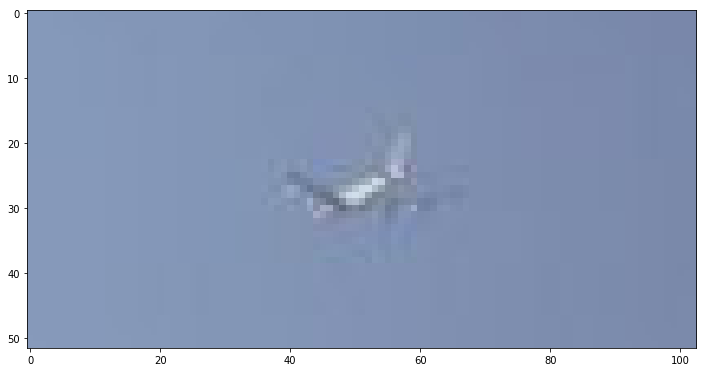

In [41]:
image = Image.open("test.jpg")
image_np = load_image_into_numpy_array(image)
    
results = run_model(image_np)

print("Number of objects detected = %d"%len(results))

for res in results:
    plt.figure(figsize=IMAGE_SIZE)
    print(res)
    plt.imshow(results[res])